In [2]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [3]:
result_dir='problem_classification_results'
seeds=[200,400,600,800,1000]
visualizations_dir='problem_classification_visualizations'
seed_mapping={index:seed for index,seed in enumerate(seeds)}

In [4]:
all_algorithms=['DE','ES','PSO']
all_stats=['min','max','mean','std']
all_dimensions=[3,5,10,20]

In [5]:
def get_global_file_name(dimension,algorithms, iteration_start,iteration_end, train_on_seed,seed, difference,stat=None, normalize_y=False):
    
    file_name=f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_100_{"train" if train_on_seed else "test"}_on_seed_{seed}{"_differenced" if difference else ""}'
    if stat is None:
        return os.path.join(result_dir + f'_normalize_{normalize_y}' ,file_name)
    else:
        return os.path.join(result_dir+ f'_normalize_{normalize_y}',f'stat_{stat}_' + file_name)


def get_visualization_output_name_without_seed(dimension,algorithms, iteration_start,iteration_end, train_on_seed, difference):
    return os.path.join(visualizations_dir,f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_100_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}')

In [6]:
def get_seed_accuracies_df(dimension,algorithm, iteration_start, iteration_end, train_on_seed, difference, seeds, stat=None, normalize_y=False):
    seed_accuracies=[]
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(dimension,algorithm, iteration_start,iteration_end, train_on_seed,train_seed, difference, stat, normalize_y)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, index_col=[0], compression='zip').rename(columns={'seed':'test_seed'}) 
            test_df_fold['fold']=fold
            test_df_fold['train_seed']=train_seed
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])



        for test_seed in seeds:
            for fold in range(0,10):
                seed_preds_df=test_df.query('test_seed==@test_seed and fold==@fold')
                seed_accuracies+=[(accuracy_score(seed_preds_df['y'], seed_preds_df['preds']), train_seed, test_seed, fold)]


    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy','train_seed','test_seed','fold']
        return seed_accuracy_df, test_df_all
    return None

In [7]:
def plot_accuracies_per_statistics_per_dimension(all_stats,difference=False, train_on_seed=True):
    dimensions=[3,10]
    results_per_iteration=[]
    all_accuracies=pd.DataFrame()
    for stat in all_stats:
        for dimension in dimensions: 
            for algorithm in all_algorithms:
                for end_iteration in [0,2,4,9,19,29]:
                    for normalize_y in [False,True]:
                        seed_accuracy_df,_ = get_seed_accuracies_df(dimension,algorithm, 0, end_iteration, train_on_seed, difference, seeds,stat, normalize_y=normalize_y)
                        seed_accuracy_df['feature calculation budget']=end_iteration+1
                        seed_accuracy_df['dimension']=dimension
                        seed_accuracy_df['statistic']=stat
                        seed_accuracy_df['normalize_y']=normalize_y
                        all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])
                        
    all_accuracies.to_csv(os.path.join(visualizations_dir,f'{"-".join(all_stats)}_accuracies_per_statistic_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}_dim_{"-".join([str(d) for d in dimensions])}.csv'))
    fig, axes = plt.subplots(len(dimensions),2, figsize=(6,6), sharex=True, sharey=True)
    for dimension_index,dimension in enumerate(dimensions):
        for normalize_index, normalize_y in enumerate([False,True]):

            accuracies=all_accuracies.query('dimension==@dimension and normalize_y==@normalize_y')
            accuracies=accuracies.groupby(['dimension','statistic','feature calculation budget']).median()
            ax=axes[dimension_index,normalize_index] if type(axes) is np.ndarray else axes
            ax.set_title(f'Dimension: {dimension}\n Scale y: {normalize_y}')
            sns.lineplot(x="feature calculation budget", y="accuracy",
                     hue="statistic", ax=ax,style="statistic",markers=True,dashes=False,
                     data=accuracies,palette=[light_blue,dark_cyan,lime, grey], hue_order=all_stats)

            if dimension_index==0 and normalize_index==1:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else: 
                ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{"-".join(all_stats)}_accuracies_per_statistic_per_dimension_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}_dim_{"-".join([str(d) for d in dimensions])}.pdf'))
    plt.show()
    return all_accuracies

/tmp/ipykernel_11734/2544672842.py:26: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",
/tmp/ipykernel_11734/2544672842.py:26: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",
/tmp/ipykernel_11734/2544672842.py:26: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",
/tmp/ipykernel_11734/2544672842.py:26: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",


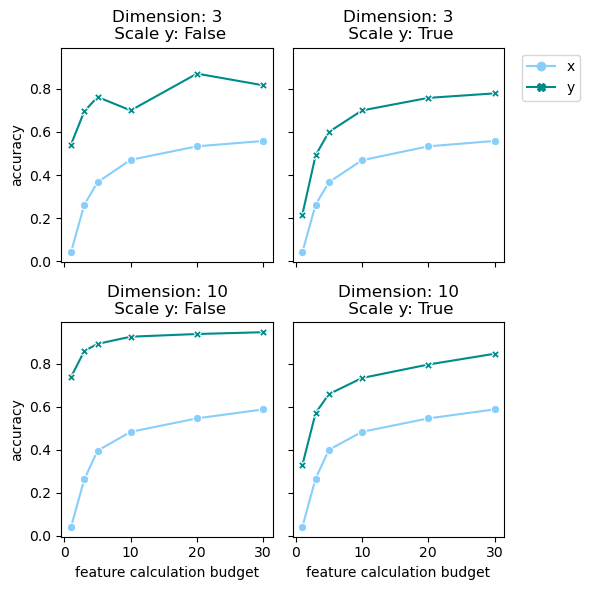

In [11]:
x_y_accuracies=plot_accuracies_per_statistics_per_dimension(['x','y'])

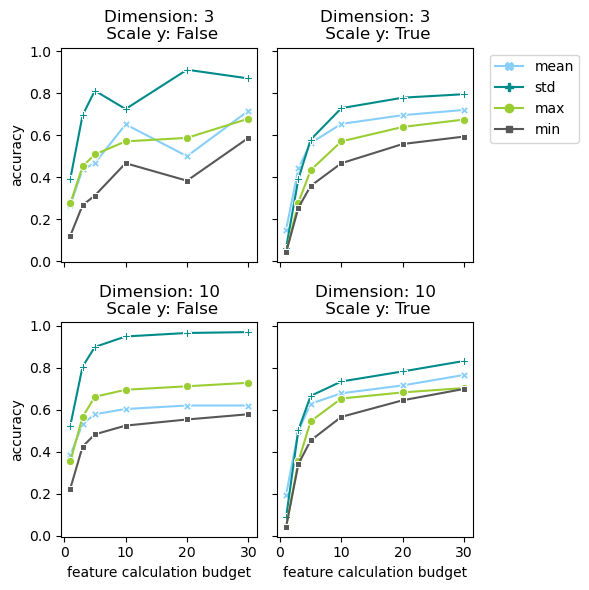

In [12]:
stat_accuracies=plot_accuracies_per_statistics_per_dimension(['mean','std','max','min'])